In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [2]:
AAPL = pd.read_csv(r"C:\Users\bolaj\Desktop\Stock Price Prediction\Stock Market Price  Prediction\Methodology\AAPL_daily_data.csv")
TSLA = pd.read_csv('C:/Users/bolaj/Desktop/Stock Price Prediction/Stock Market Price  Prediction/Methodology/TSLA_daily_data.csv')
GOOG = pd.read_csv('C:/Users/bolaj/Desktop/Stock Price Prediction/Stock Market Price  Prediction/Methodology/GOOGL_daily_data.csv')
MSFT = pd.read_csv('C:/Users/bolaj/Desktop/Stock Price Prediction/Stock Market Price  Prediction/Methodology/MSFT_daily_data.csv')
AMZN = pd.read_csv('C:/Users/bolaj/Desktop/Stock Price Prediction/Stock Market Price  Prediction/Methodology/AMZN_daily_data.csv')

In [3]:
def Test_Stationarity(timeseries):
  result = adfuller(timeseries['Adj Close'], autolag = 'AIC')
  print("Results of Dickey Fuller Test")
  print(f'Test Statistics: {result[0]}')
  print(f'p-value: {result[1]}')
  print(f'Number of lags used: {result[2]}')
  print(f'Number of observations used: {result[3]}')
  for key, value in result[4].items():
    print(f'critical value ({key}): {value}')

## APPLE

### Preamble

In [4]:
AAPL.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-01-02,19.845715,19.893929,19.715000,19.754642,17.253258,234684800
1,2014-01-03,19.745001,19.775000,19.301071,19.320715,16.874277,392467600
2,2014-01-06,19.194643,19.528570,19.057142,19.426071,16.966291,412610800
3,2014-01-07,19.440001,19.498571,19.211430,19.287144,16.844963,317209200
4,2014-01-08,19.243214,19.484285,19.238930,19.409286,16.951632,258529600


In [5]:
AAPL.shape

(2577, 7)

In [6]:
AAPL.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2577 entries, 0 to 2576
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2577 non-null   object 
 1   Open       2577 non-null   float64
 2   High       2577 non-null   float64
 3   Low        2577 non-null   float64
 4   Close      2577 non-null   float64
 5   Adj Close  2577 non-null   float64
 6   Volume     2577 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 141.1+ KB


In [7]:
AAPL.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [8]:
# Change Dtype of Date column
AAPL["Date"] = pd.to_datetime(AAPL["Date"])

In [9]:
max_date = AAPL["Date"].max()
max_date

Timestamp('2024-03-28 00:00:00')

In [10]:
min_date = AAPL["Date"].min()
min_date


Timestamp('2014-01-02 00:00:00')

In [11]:
AAPL.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-01-02,19.845715,19.893929,19.715000,19.754642,17.253258,234684800
1,2014-01-03,19.745001,19.775000,19.301071,19.320715,16.874277,392467600
2,2014-01-06,19.194643,19.528570,19.057142,19.426071,16.966291,412610800
3,2014-01-07,19.440001,19.498571,19.211430,19.287144,16.844963,317209200
4,2014-01-08,19.243214,19.484285,19.238930,19.409286,16.951632,258529600


In [12]:
Test_Stationarity(AAPL)

Results of Dickey Fuller Test
Test Statistics: -0.24928801206986156
p-value: 0.9323859039420437
Number of lags used: 18
Number of observations used: 2558
critical value (1%): -3.4329089813516065
critical value (5%): -2.8626705556366505
critical value (10%): -2.56737183663938


In [13]:
# Function to detect outliers using IQR (Interquartile Range)
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Return a boolean series where True indicates an outlier
    return (df[column] < lower_bound) | (df[column] > upper_bound)

In [14]:
# Detect outliers for each numeric column (Open, High, Low, Close, Adj Close, Volume)
for column in ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']:
    outliers = detect_outliers_iqr(AAPL, column)
    num_outliers = outliers.sum()
    print(f"Number of outliers in {column}: {num_outliers}")

Number of outliers in Open: 0
Number of outliers in High: 0
Number of outliers in Low: 0
Number of outliers in Close: 0
Number of outliers in Adj Close: 0
Number of outliers in Volume: 125


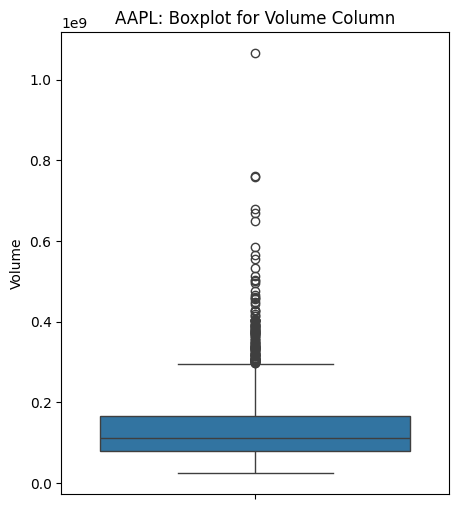

In [15]:
# Visualize the Volume column separately
plt.figure(figsize=(5, 6))
sns.boxplot(data=AAPL['Volume'])
plt.title('AAPL: Boxplot for Volume Column')
plt.ylabel('Volume')

plt.savefig('AAPLvolume_boxplot.png', format='png', dpi=300, bbox_inches='tight')

plt.show()

In [16]:
# Get the rows where Volume is an outlier
AAPLvolume_outliers = AAPL[detect_outliers_iqr(AAPL, 'Volume')]

# Display the outliers
AAPLvolume_outliers


,Date,Open,High,Low,Close,Adj Close,Volume
1,2014-01-03,19.745001,19.775000,19.301071,19.320715,16.874277,392467600
2,2014-01-06,19.194643,19.528570,19.057142,19.426071,16.966291,412610800
3,2014-01-07,19.440001,19.498571,19.211430,19.287144,16.844963,317209200
6,2014-01-10,19.279642,19.314285,18.968214,19.033571,16.623495,304976000
7,2014-01-13,18.925358,19.375000,18.924286,19.133215,16.710518,378492800
...,...,...,...,...,...,...,...
1656,2020-07-31,102.885002,106.415001,100.824997,106.260002,103.655151,374336800
1657,2020-08-03,108.199997,111.637497,107.892502,108.937500,106.267014,308151200
1671,2020-08-21,119.262497,124.867500,119.250000,124.370003,121.539940,338054800
1672,2020-08-24,128.697495,128.785004,123.937500,125.857498,122.993591,345937600


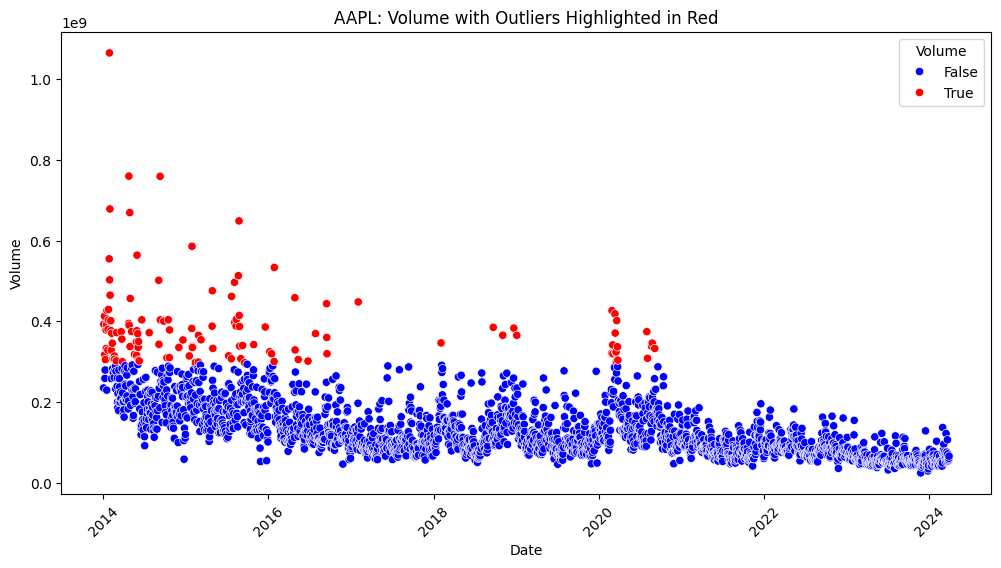

In [17]:
# Create a scatter plot for Volume highlighting outliers
plt.figure(figsize=(12, 6))
sns.scatterplot(data=AAPL, x='Date', y='Volume', hue=detect_outliers_iqr(AAPL, 'Volume'), palette={False: 'blue', True: 'red'})
plt.title('AAPL: Volume with Outliers Highlighted in Red')
plt.xticks(rotation=45)

# Save the figure as a PNG file
plt.savefig('AAPLvolume_scatterplot_outliers.png', format='png', dpi=300, bbox_inches='tight')

plt.show()


In [18]:
# Summary statistics for outliers and non-outliers
print("Non-outlier Volume statistics:")
print(AAPL[~detect_outliers_iqr(AAPL, 'Volume')]['Volume'].describe())

print("\nOutlier Volume statistics:")
print(AAPL[detect_outliers_iqr(AAPL, 'Volume')]['Volume'].describe())


Non-outlier Volume statistics:
count    2.452000e+03
mean     1.219882e+08
std      5.793747e+07
min      2.404830e+07
25%      7.765910e+07
50%      1.077101e+08
75%      1.543621e+08
max      2.942472e+08
Name: Volume, dtype: float64

Outlier Volume statistics:
count    1.250000e+02
mean     3.881492e+08
std      1.085855e+08
min      2.971412e+08
25%      3.224236e+08
50%      3.652488e+08
75%      4.032392e+08
max      1.065523e+09
Name: Volume, dtype: float64


Text(0.5, 1.0, 'Rolling Mean and Standard Deviation')

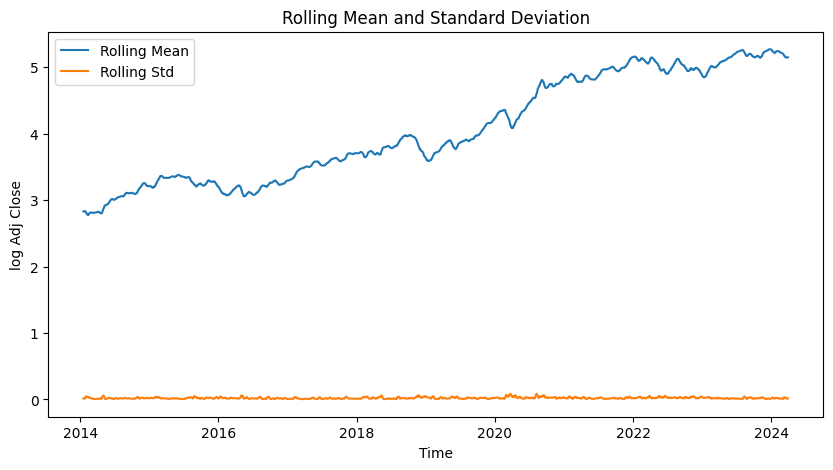

In [19]:
AAPL['log Adj Close'] = np.log(AAPL['Adj Close'])
AAPL_log_moving_avg = AAPL['log Adj Close'].rolling(12).mean()
AAPL_log_std = AAPL['log Adj Close'].rolling(12).std()

plt.figure(figsize = (10, 5))
plt.plot(AAPL['Date'], AAPL_log_moving_avg, label = "Rolling Mean")
plt.plot(AAPL['Date'], AAPL_log_std, label = "Rolling Std")
plt.xlabel('Time')
plt.ylabel('log Adj Close')
plt.legend(loc = 'best')
plt.title("Rolling Mean and Standard Deviation")

### Split the data into training and test set
Training Period: 2014-01-01 - 2023-09-30

Testing Period:  2023-10-01 - 2024-04-01

In [20]:
AAPL.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'log Adj Close'],
      dtype='object')

In [21]:
Base_AAPL = AAPL.set_index('Date')

In [22]:
Base_AAPL.head()

,Open,High,Low,Close,Adj Close,Volume,log Adj Close
Date,,,,,,,
2014-01-02,19.845715,19.893929,19.715000,19.754642,17.253258,234684800,2.848001
2014-01-03,19.745001,19.775000,19.301071,19.320715,16.874277,392467600,2.825790
2014-01-06,19.194643,19.528570,19.057142,19.426071,16.966291,412610800,2.831229
2014-01-07,19.440001,19.498571,19.211430,19.287144,16.844963,317209200,2.824052
2014-01-08,19.243214,19.484285,19.238930,19.409286,16.951632,258529600,2.830364


In [23]:
# Define new feature set including the original and engineered features
X_base = Base_AAPL[[ 'Open', 'High', 'Low','Adj Close', 'Volume']]
y_base = Base_AAPL['Close']

In [24]:
# Train-test split (80% train, 20% test)
X_trainbase, X_testbase, y_trainbase, y_testbase = train_test_split(X_base, y_base, test_size=0.2, shuffle=False)

# Standardize the features
scaler = StandardScaler()
X_train_scaledbase = scaler.fit_transform(X_trainbase)
X_test_scaledbase = scaler.transform(X_testbase)

### Model Trainig & Prediction

In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Function to calculate RMSE, MAE, and R²
def evaluate_model(true_values, predicted_values, model_name):
    rmse = np.sqrt(mean_squared_error(true_values, predicted_values))
    mae = mean_absolute_error(true_values, predicted_values)
    r2 = r2_score(true_values, predicted_values)
    
    print(f'{model_name} Evaluation:')
    print(f'  RMSE: {rmse:.4f}')
    print(f'  MAE: {mae:.4f}')
    print(f'  R²: {r2:.4f}\n')
    
    return rmse, mae, r2


#### Arima Baseline

##### AutoArima

In [26]:
# Train the AutoARIMA model
AAPL_Auto_ARIMA_Model = auto_arima(y_trainbase, seasonal=False, stepwise=True)

In [27]:
# AAPL_Auto_ARIMA_Model = auto_arima(AAPL_Train_Data['log Adj Close'], seasonal = False,
#                                    error_action = 'ignore', suppress_warnings = True)
print(AAPL_Auto_ARIMA_Model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2061
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -3581.542
Date:                Fri, 20 Sep 2024   AIC                           7169.085
Time:                        19:41:00   BIC                           7185.976
Sample:                             0   HQIC                          7175.278
                               - 2061                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0732      0.030      2.406      0.016       0.014       0.133
ar.L1         -0.0539      0.011     -4.961      0.000      -0.075      -0.033
sigma2         1.8952      0.023     81.539      0.0

In [28]:
auto_arima_fitted = AAPL_Auto_ARIMA_Model.fit(y_trainbase)

In [29]:
# Predictions
AAPL_Auto_ARIMA_Model_pred = auto_arima_fitted.predict(n_periods=len(y_testbase))

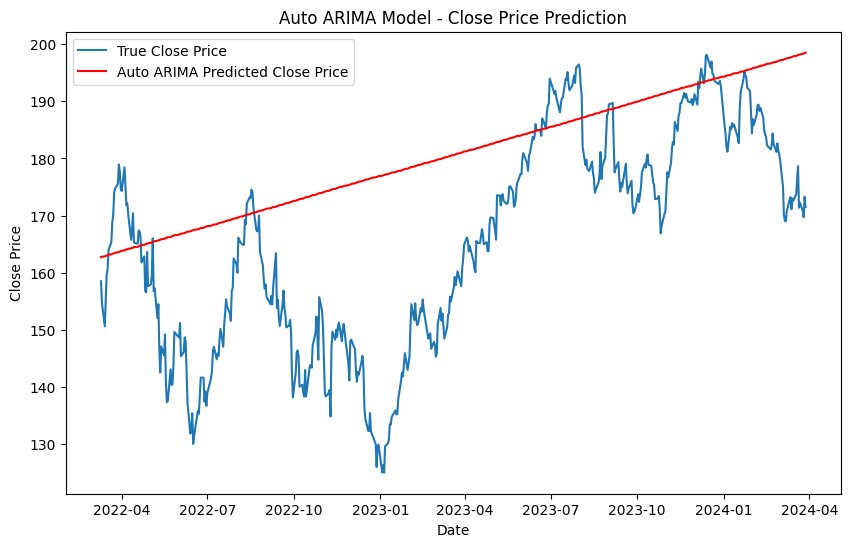

In [30]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(y_testbase.index, y_testbase, label='True Close Price')
plt.plot(y_testbase.index, AAPL_Auto_ARIMA_Model_pred, label='Auto ARIMA Predicted Close Price', color='red')
plt.title('Auto ARIMA Model - Close Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [31]:
# Evaluate Auto ARIMA model predictions
auto_arima_rmse, auto_arima_mae, auto_arima_r2 = evaluate_model(y_testbase, AAPL_Auto_ARIMA_Model_pred, "Auto ARIMA")

Auto ARIMA Evaluation:
  RMSE: 20.4838
  MAE: 16.7096
  R²: -0.2315



##### Arima

In [32]:
# ARIMA Model (let's assume p=5, d=1, q=0 as an example)
AAPL_arima_model = ARIMA(y_trainbase, order=(5, 1, 0))
AAPL_arima_fitted = AAPL_arima_model.fit()

In [33]:
# Predicting on test set
AAPL_arima_pred = AAPL_arima_fitted.predict(start=len(y_trainbase), end=len(y_trainbase)+len(y_testbase)-1, typ='levels')

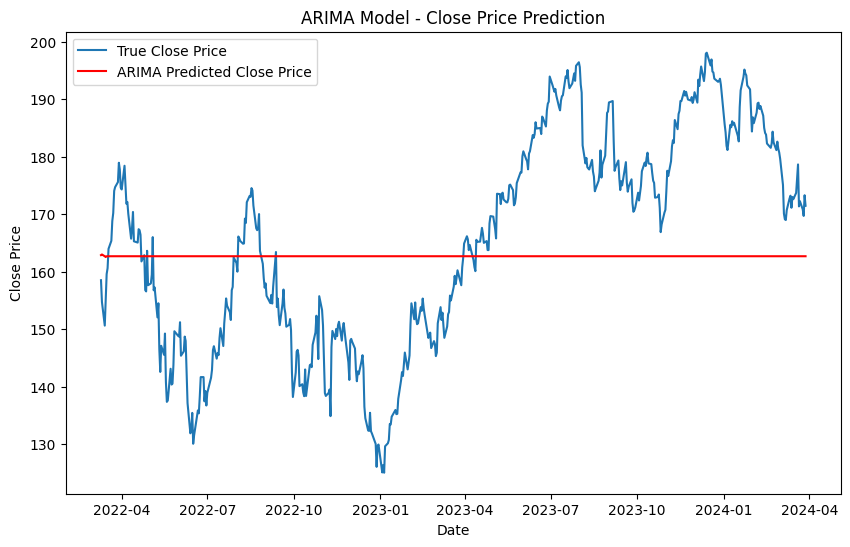

In [34]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(y_testbase.index, y_testbase, label='True Close Price')
plt.plot(y_testbase.index, AAPL_arima_pred, label='ARIMA Predicted Close Price', color='red')
plt.title('ARIMA Model - Close Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [35]:
# Evaluate ARIMA model predictions
arima_rmse, arima_mae, arima_r2 = evaluate_model(y_testbase, AAPL_arima_pred, "ARIMA")

ARIMA Evaluation:
  RMSE: 18.6515
  MAE: 16.2801
  R²: -0.0210



### Feature Engineering

In [36]:
# Simple Moving Average (SMA)
AAPL['SMA_20'] = AAPL['Close'].rolling(window=20).mean()

In [37]:
# Rate of Change (RoC)
AAPL['RoC_10'] = AAPL['Close'].pct_change(periods=10) * 100  # RoC for 10 days

In [38]:
AAPL.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,log Adj Close,SMA_20,RoC_10
2572,2024-03-22,171.759995,173.050003,170.059998,172.279999,171.847717,71106600,5.146609,174.7270,0.907868
2573,2024-03-25,170.570007,171.940002,169.449997,170.850006,170.421326,54288300,5.138274,174.2115,-1.099852
2574,2024-03-26,170.000000,171.419998,169.580002,169.710007,169.284180,57388400,5.131579,173.5655,-2.031974
2575,2024-03-27,170.410004,173.600006,170.110001,173.309998,172.875137,60273300,5.152570,173.1600,1.273881
2576,2024-03-28,171.750000,172.229996,170.509995,171.479996,171.049728,65672700,5.141954,172.6965,-0.878615


In [39]:
def compute_rsi(series, period=14):
    delta = series.diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=period, min_periods=1).mean()
    avg_loss = loss.rolling(window=period, min_periods=1).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

AAPL['RSI_14'] = compute_rsi(AAPL['Close'], period=14)


In [40]:
AAPL.sample(frac=0.0045)

,Date,Open,High,Low,Close,Adj Close,Volume,log Adj Close,SMA_20,RoC_10,RSI_14
1658,2020-08-04,109.132500,110.790001,108.387497,109.665001,106.976677,173071600,4.672611,97.618500,13.056702,69.979931
2134,2022-06-24,139.899994,141.910004,139.770004,141.660004,139.913300,89116800,4.941023,141.149001,-0.687041,45.541702
1999,2021-12-09,174.910004,176.750000,173.919998,174.559998,171.935608,108923700,5.147120,160.700001,7.793007,73.904306
2249,2022-12-07,142.190002,143.369995,140.000000,140.940002,139.626770,69721100,4.938973,146.897498,-6.152611,38.195508
2182,2022-09-01,156.639999,158.419998,154.669998,157.960007,156.228989,74229900,5.051323,167.143002,-9.296576,23.260231
1200,2018-10-08,55.552502,56.200001,55.049999,55.942501,53.305248,118655600,3.976035,55.826250,1.349704,59.092401
944,2017-10-02,38.564999,38.612499,38.180000,38.452499,36.094017,74795200,3.586127,39.274125,-3.062961,31.839239
871,2017-06-19,35.915001,36.685001,35.915001,36.584999,34.206722,130165600,3.532422,37.768250,-4.930811,35.941688
1572,2020-04-01,61.625000,62.180000,59.782501,60.227501,58.592472,176218400,4.070606,64.047625,-2.335101,47.885617
895,2017-07-24,37.645000,38.110001,37.474998,38.022499,35.550785,85972800,3.570962,36.676000,4.846270,83.528485


In [41]:
# Price Range (High - Low)
AAPL['Price_Range'] = AAPL['High'] - AAPL['Low']

In [42]:
AAPL.sample(frac=0.00045)

,Date,Open,High,Low,Close,Adj Close,Volume,log Adj Close,SMA_20,RoC_10,RSI_14,Price_Range
1535,2020-02-07,80.592499,80.849998,79.5,80.0075,77.835503,117684000,4.354598,79.195625,0.540354,50.957282,1.349998


In [43]:
# Stock Returns
AAPL['Returns'] = AAPL['Close'].pct_change() * 100

In [44]:
# 1. Bollinger Bands
def bollinger_bands(data, window=20, num_sd=2):
    sma = data['Close'].rolling(window=window).mean()
    rolling_std = data['Close'].rolling(window=window).std()
    data['Bollinger_Upper'] = sma + (rolling_std * num_sd)
    data['Bollinger_Lower'] = sma - (rolling_std * num_sd)
    return data

AAPL = bollinger_bands(AAPL)

In [45]:
# 2. Exponential Moving Averages (EMA)
AAPL['EMA_12'] = AAPL['Close'].ewm(span=12, adjust=False).mean()  # 12-day EMA
AAPL['EMA_26'] = AAPL['Close'].ewm(span=26, adjust=False).mean()  # 26-day EMA

In [46]:
# 3. MACD
AAPL['MACD'] = AAPL['EMA_12'] - AAPL['EMA_26']
AAPL['MACD_Signal'] = AAPL['MACD'].ewm(span=9, adjust=False).mean()  # Signal line (9-day EMA of MACD)

In [47]:
# Drop rows with NaN values after feature engineering
AAPL.dropna(inplace=True)

In [48]:
AAPL.head()

,Date,Open,High,Low,Close,Adj Close,Volume,log Adj Close,SMA_20,RoC_10,RSI_14,Price_Range,Returns,Bollinger_Upper,Bollinger_Lower,EMA_12,EMA_26,MACD,MACD_Signal
19,2014-01-30,17.947857,18.089287,17.739286,17.849285,15.589162,678501600,2.746576,19.260286,-10.330847,35.357867,0.350000,-0.193711,20.499702,18.020870,18.934954,19.252245,-0.317291,-0.135755
20,2014-01-31,17.684999,17.911785,17.626785,17.878571,15.614739,464797200,2.748215,19.166482,-9.679754,36.821497,0.285000,0.164071,20.526474,17.806491,18.772433,19.150491,-0.378057,-0.184216
21,2014-02-03,17.950357,18.133215,17.832144,17.911785,15.643751,401464000,2.750072,19.096036,-7.239169,35.849028,0.301071,0.185779,20.564061,17.628011,18.640026,19.058735,-0.418709,-0.231114
22,2014-02-04,18.066071,18.195000,17.955713,18.171070,15.870200,376681200,2.764443,19.033286,-7.336053,33.991781,0.239286,1.447566,20.548444,17.518127,18.567879,18.992982,-0.425103,-0.269912
23,2014-02-05,18.091429,18.402857,18.080357,18.306786,15.988731,328344800,2.771884,18.984268,-7.056995,29.699815,0.322500,0.746877,20.528009,17.440526,18.527711,18.942153,-0.414442,-0.298818


In [49]:
AAPL.set_index('Date', inplace=True)

In [50]:
AAPL.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'log Adj Close',
       'SMA_20', 'RoC_10', 'RSI_14', 'Price_Range', 'Returns',
       'Bollinger_Upper', 'Bollinger_Lower', 'EMA_12', 'EMA_26', 'MACD',
       'MACD_Signal'],
      dtype='object')

### Arima Model Retraining

In [51]:
# Define new feature set including the original and engineered features
X = AAPL[['Open', 'High', 'Low', 'Adj Close', 'Volume',
    'SMA_20', 'RoC_10', 'RSI_14', 'Price_Range', 'Returns',
       'Bollinger_Upper', 'Bollinger_Lower', 'EMA_12', 'EMA_26', 'MACD',
       'MACD_Signal']]
y = AAPL['Close']

In [52]:
# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [53]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# TimeSeriesSplit for cross-validation (5 folds)
tscv = TimeSeriesSplit(n_splits=5)

In [54]:
import itertools

# Define the p, d, q ranges to search over
p = range(0, 5)
d = range(0, 2)
q = range(0, 5)
pdq = list(itertools.product(p, d, q))

# Grid search over p, d, q combinations
best_aic = np.inf
best_order = None
best_model = None

for order in pdq:
    try:
        model = ARIMA(y_train, order=order)
        results = model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_order = order
            best_model = results
    except:
        continue

print(f"Best ARIMA model: Order {best_order} with AIC {best_aic}")

Best ARIMA model: Order (4, 1, 4) with AIC 7130.505825479349


In [55]:
# Perform auto_arima with cross-validation
auto_arima_model_fe = auto_arima(y_train, 
                              exogenous=X_train_scaled,  # Using the new features
                              seasonal=False, 
                              trace=True,
                              error_action='ignore', 
                              suppress_warnings=True,
                              stepwise=True,
                              cv=tscv,
                              start_p=0, 
                              start_q=0, 
                              max_p=5, 
                              max_q=5, 
                              d=1)

# Print the best order found
print(f"Best Auto ARIMA model: {auto_arima_model_fe.order}")


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7170.954, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7166.731, Time=0.45 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7166.701, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7173.677, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7168.732, Time=0.56 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=7168.673, Time=0.49 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=7169.547, Time=1.66 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=7169.979, Time=0.13 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 4.262 seconds
Best Auto ARIMA model: (0, 1, 1)


##### Prediciton and Evaluation

In [56]:
# Fit ARIMA with best hyperparameters
arima_fitted_fe = ARIMA(y_train, order=best_order).fit()

# Predict on the test set
arima_pred_fe = arima_fitted_fe.predict(start=len(y_train), end=len(y_train)+len(y_test)-1, typ='levels')

# Evaluate the ARIMA model
arima_rmse, arima_mae, arima_r2 = evaluate_model(y_test, arima_pred_fe, "ARIMA with Feature Engineering")

ARIMA with Feature Engineering Evaluation:
  RMSE: 21.1550
  MAE: 17.9343
  R²: -0.3069



In [57]:
# Predict with the optimized Auto ARIMA model
auto_arima_pred_fe = auto_arima_model_fe.predict(n_periods=len(y_test), exogenous=X_test_scaled)

# Evaluate the Auto ARIMA model
auto_arima_rmse, auto_arima_mae, auto_arima_r2 = evaluate_model(y_test, auto_arima_pred_fe, "Auto ARIMA with Feature Engineering")

Auto ARIMA with Feature Engineering Evaluation:
  RMSE: 15.2726
  MAE: 12.2792
  R²: 0.3188



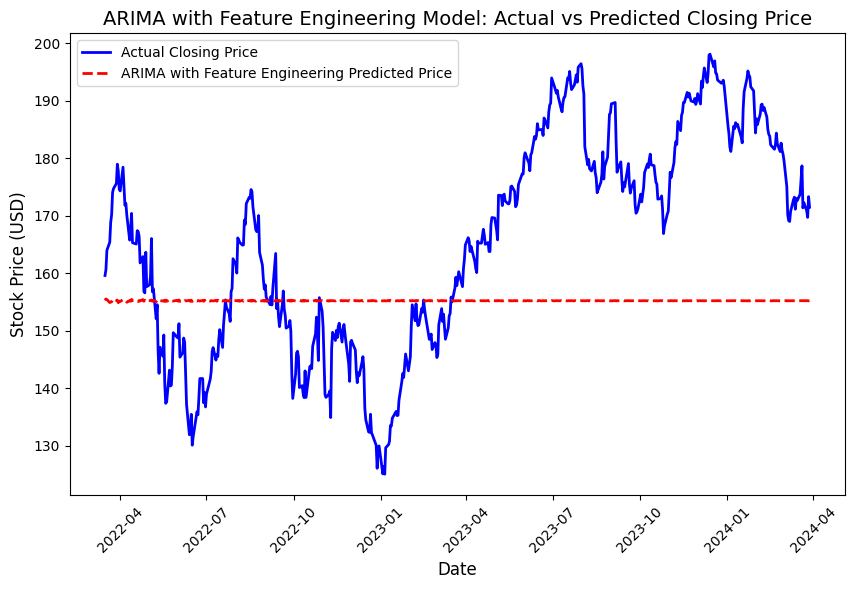

In [58]:
def plot_predictions(actual, predicted, model_name):
    plt.figure(figsize=(10, 6))
    
    plt.plot(actual.index, actual, color='blue', label='Actual Closing Price', linewidth=2)
    plt.plot(actual.index, predicted, color='red', linestyle='--', label=f'{model_name} Predicted Price', linewidth=2)

    plt.title(f'{model_name} Model: Actual vs Predicted Closing Price', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Stock Price (USD)', fontsize=12)
    plt.legend(loc='upper left')
    plt.xticks(rotation=45)
    
    plt.show()

# Plot ARIMA predictions
plot_predictions(y_test, arima_pred_fe, "ARIMA with Feature Engineering")


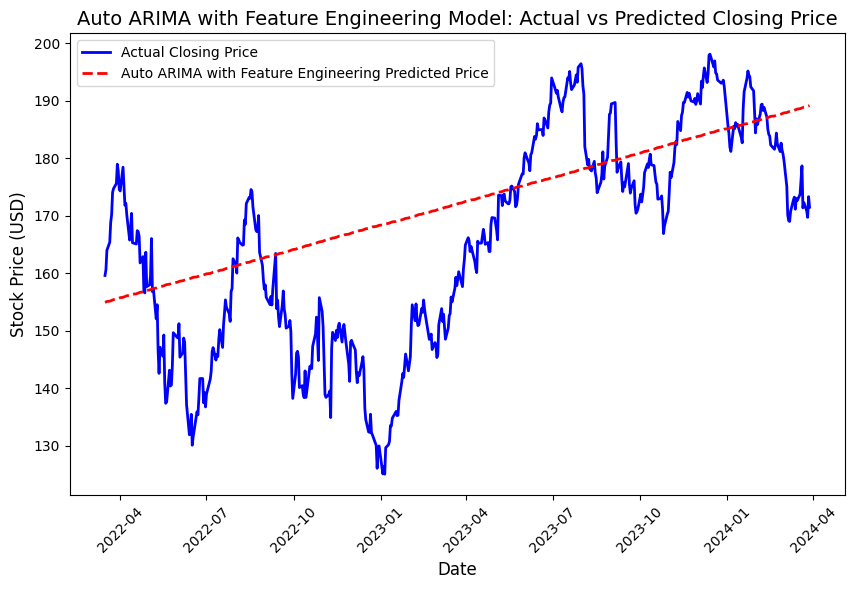

In [59]:
# Plot Auto ARIMA predictions
plot_predictions(y_test, auto_arima_pred_fe, "Auto ARIMA with Feature Engineering")


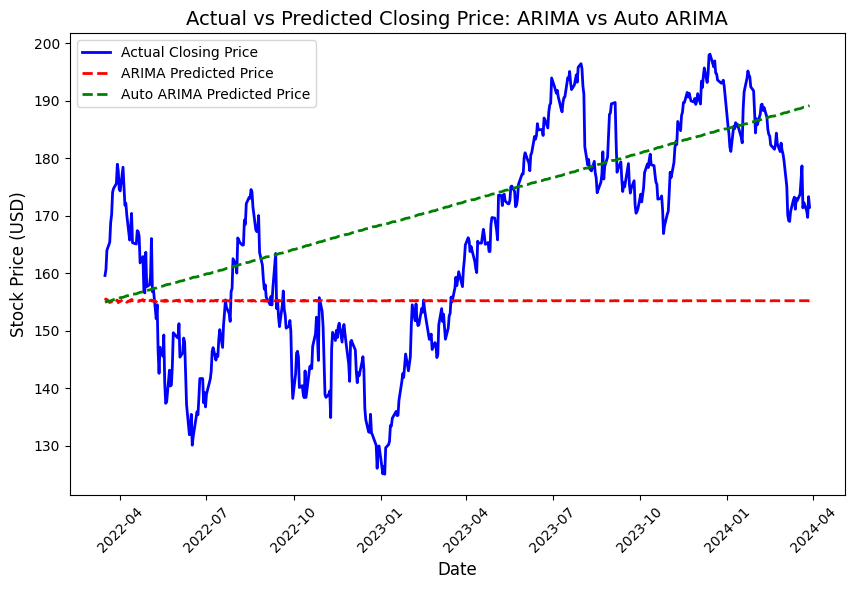

In [60]:
plt.figure(figsize=(10, 6))

# Actual Closing Price
plt.plot(y_test.index, y_test, color='blue', label='Actual Closing Price', linewidth=2)

# ARIMA Predicted Closing Price
plt.plot(y_test.index, arima_pred_fe, color='red', linestyle='--', label='ARIMA Predicted Price', linewidth=2)

# Auto ARIMA Predicted Closing Price
plt.plot(y_test.index, auto_arima_pred_fe, color='green', linestyle='--', label='Auto ARIMA Predicted Price', linewidth=2)

plt.title('Actual vs Predicted Closing Price: ARIMA vs Auto ARIMA', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Stock Price (USD)', fontsize=12)
plt.legend(loc='upper left')
plt.xticks(rotation=45)

plt.show()


### Random Forest

In [62]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [63]:
# Baseline model
baseline_model = RandomForestRegressor(random_state=42)
baseline_model.fit(X_train_scaledbase, y_trainbase)

RandomForestRegressor(random_state=42)

In [67]:
# Predict and evaluate
R_baseline_predictions = baseline_model.predict(X_test_scaledbase)

In [69]:
R_baseline_rmse, R_baseline_mae, R_baseline_r2 = evaluate_model(y_testbase, R_baseline_predictions, "Random Forest")

Random Forest Evaluation:
  RMSE: 4.6464
  MAE: 2.6459
  R²: 0.9366



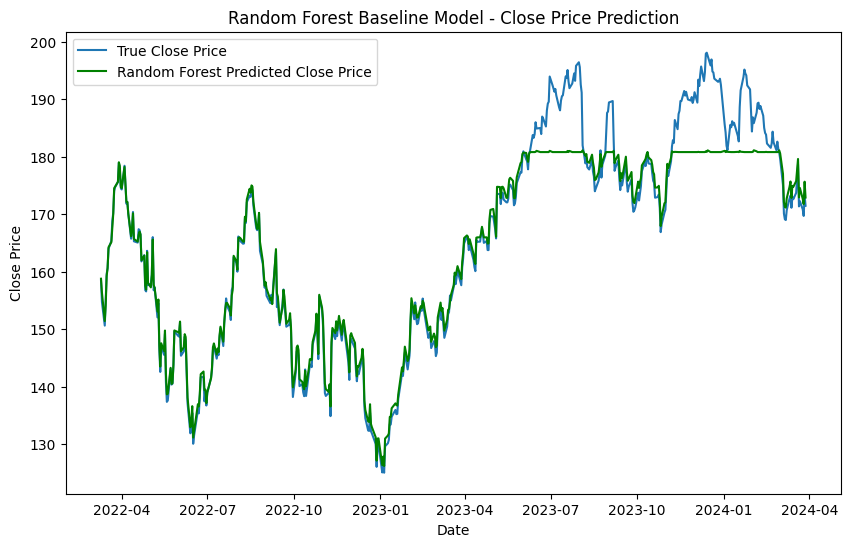

In [70]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(y_testbase.index, y_testbase, label='True Close Price')
plt.plot(y_testbase.index, R_baseline_predictions, label='Random Forest Predicted Close Price', color='green')
plt.title('Random Forest Baseline Model - Close Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

##### Random Forest Final Prediction

In [71]:
from sklearn.model_selection import GridSearchCV

# Define the model
rf_model = RandomForestRegressor(random_state=42)


In [74]:
# Define the grid of hyperparameters to search
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [None, 10],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4]
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=rf_model,
                           param_grid=param_grid,
                           cv=10,  # 5-fold cross-validation
                           n_jobs=-1,  # Use all available cores
                           verbose=1,
                           scoring='neg_mean_squared_error')

In [75]:

# Fit GridSearchCV
grid_search.fit(X_train_scaled, y_train)

Fitting 10 folds for each of 48 candidates, totalling 480 fits


GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [2, 4],
                         'min_samples_split': [5, 10],
                         'n_estimators': [100, 150, 200]},
             scoring='neg_mean_squared_error', verbose=1)

In [ ]:
# Best parameters and model
best_rf_model = grid_search.best_estimator_
print("Best Random Forest Parameters:", grid_search.best_params_)

In [ ]:
# Predict and evaluate final model
final_predictions = best_rf_model.predict(X_test_scaled)

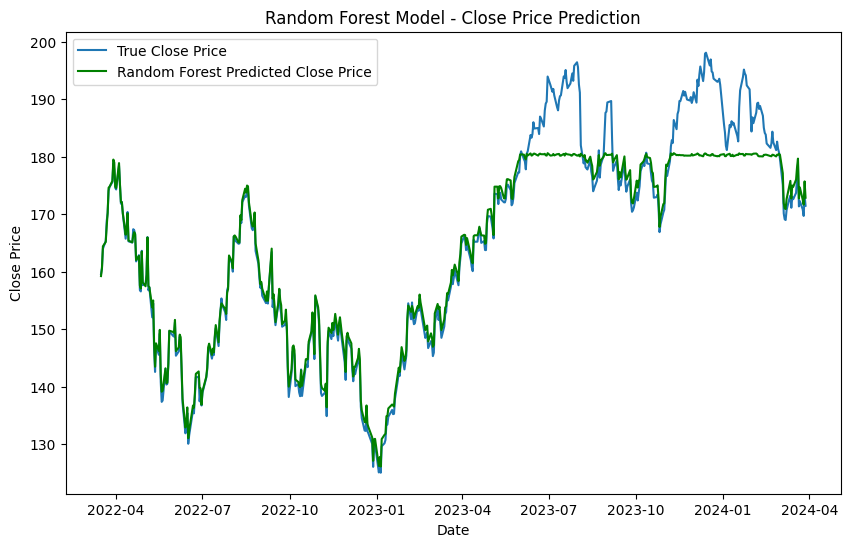

In [79]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='True Close Price')
plt.plot(y_test.index, rf_pred, label='Random Forest Predicted Close Price', color='green')
plt.title('Random Forest Model - Close Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [81]:
# Evaluate Random Forest model predictions
rf_rmse, rf_mae, rf_r2 = evaluate_model(y_test, rf_pred, "Random Forest")

Random Forest Evaluation:
  RMSE: 4.8838
  MAE: 2.8104
  R²: 0.9303



#### SVM

In [82]:
from sklearn.svm import SVR

# SVM model
svm_model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.01)
svm_model.fit(X_train_scaled, y_train)


SVR(C=100, epsilon=0.01, gamma=0.1)

In [83]:
# Predicting on test set
svm_pred = svm_model.predict(X_test_scaled)


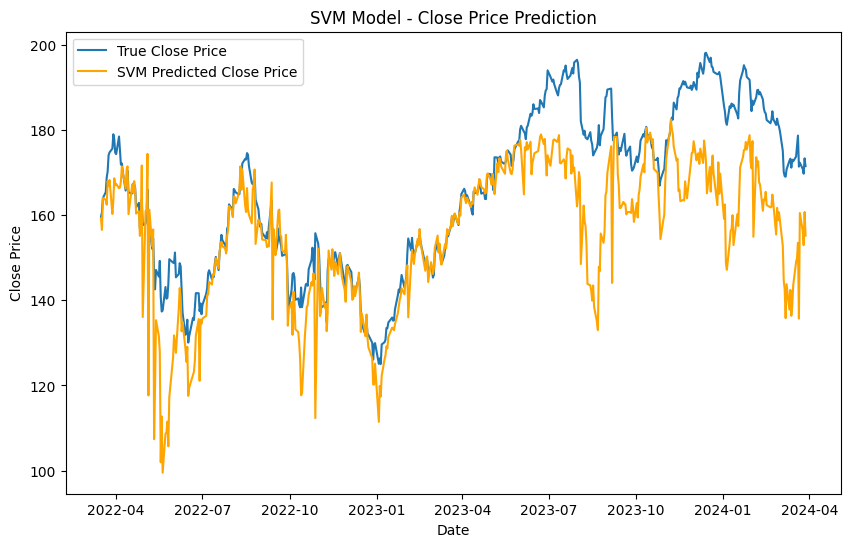

In [84]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='True Close Price')
plt.plot(y_test.index, svm_pred, label='SVM Predicted Close Price', color='orange')
plt.title('SVM Model - Close Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [85]:
# Evaluate SVM model predictions
svm_rmse, svm_mae, svm_r2 = evaluate_model(y_test, svm_pred, "SVM")

SVM Evaluation:
  RMSE: 14.9291
  MAE: 10.4113
  R²: 0.3491



#### LSTM

In [86]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


In [87]:
# Reshape the input data to 3D for LSTM [samples, time steps, features]
X_train_lstm = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

In [88]:
# LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=50, return_sequences=False))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(units=1))  # Predicting one value (Close price)

In [89]:
# Compile the model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')



In [90]:
# Train the model
lstm_model.fit(X_train_lstm, y_train, epochs=20, batch_size=32)


Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 5307.3813
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4680.3882
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4438.4727
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4096.7490
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3381.7617
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3396.3472
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2968.5715
Epoch 8/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2894.2642
Epoch 9/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2809.9114
Epoch 10/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2538.7380
Epoch 11/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2537.4871
Epoch 12/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2328.8950
Epoch 13/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2199.4832
Epoch 14/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2154.7588
Epoch 15/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3

In [91]:
# Predicting on test set
lstm_pred = lstm_model.predict(X_test_lstm)
lstm_pred = np.squeeze(lstm_pred)  # Reshape to 1D


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step   


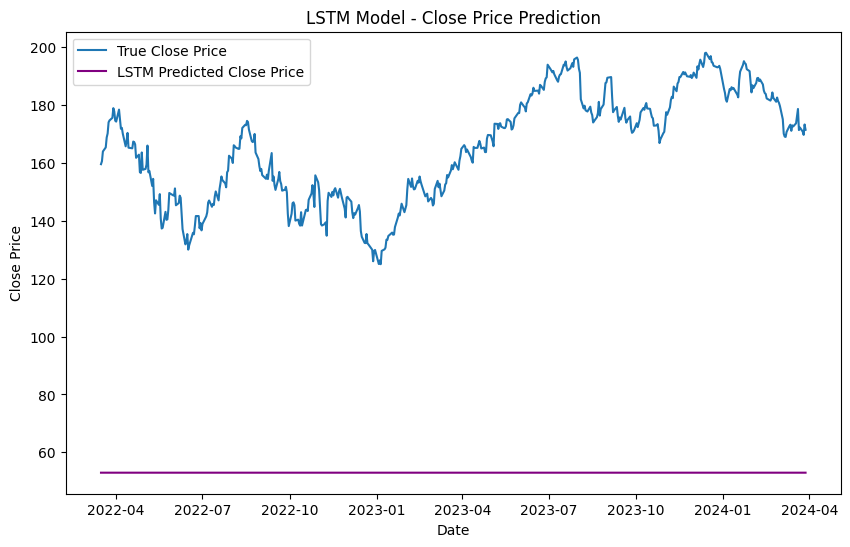

In [92]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='True Close Price')
plt.plot(y_test.index, lstm_pred, label='LSTM Predicted Close Price', color='purple')
plt.title('LSTM Model - Close Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [93]:
# Evaluate LSTM model predictions
lstm_rmse, lstm_mae, lstm_r2 = evaluate_model(y_test, lstm_pred, "LSTM")

LSTM Evaluation:
  RMSE: 114.0000
  MAE: 112.4882
  R²: -36.9520

